# Produces APE timeseries for each exp and generates ncfiles for Fig 9
magnitude_drag_APE_cdwonly_relsponging.nc and magnitude_wind_APE_cdwonly_relsponging.nc files for Fig 9

### Calculation for fixed point in model between EKE and APE




\begin{equation} \frac{dE}{dt} = \mathcal X E  \end{equation}
\begin{equation}  \rightarrow E = e^{\pm i \omega t} \text{    where   } \omega = \sqrt{ab/2} \end{equation}

In [1]:
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=26) #20 
rc('ytick', labelsize=26) #20
rc('axes', titlesize=26)    # fontsize of the axes title
rc('axes', labelsize=26) #24  
rc('font', **{'size':26})
import matplotlib.pyplot as plt

In [2]:
H =  3000 #ASC[m]  ### ACC rho = 1026.89 drho = 1.2 H  = 2000 
#ACC values -- give freq of 420days but ACC so dynamics will be differnt!
drho = 0.1 #original--> before used 0.5 for diff relative to AABW layer
Hrho = 1000 ## combined height of top two layers to use for buoyancy frequency calculation

drho_dz = -drho/(Hrho/2)
f = -1e-4
g = 9.81
rho0 = 1027.8 #[kg/m^3
tau = 0.05
gp = drho/rho0 *g
print(gp)
#htop = 200 #[m] height of top layer thickness

Nsquared = - g/rho0 * drho_dz

0.0009544658493870405


In [3]:
Nsquared

1.908931698774081e-06

In [4]:
Ly = 200e3 #np.sqrt(Nsquared) * H /f #2e4 #7e3 #rossby deformation radius
print(Ly)

a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
a = (2 *gp /(np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))

a

200000.0


1.2734153133564038e-11

In [5]:
b = (2*tau*gp*Ly/f) *np.sqrt(6/(rho0*gp*Ly**3))
b = (2*tau*gp*Ly/abs(f)) *np.sqrt(6/(rho0*gp*Ly**3))

b

0.005278208207829867

In [6]:
T = 2*np.pi/np.sqrt(a*b/2)/ (60*60*24)
T

396.6914414938687

In [7]:
def MAPE_predict(cdrag):
    a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
    a = (2 *gp /(np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))

    MAPE  = (cdrag/a)**2
    print(cdrag, MAPE)
    return MAPE

In [8]:
MAPE_predict(1e-8)

1e-08 616680.0000000001


616680.0000000001

In [9]:
def E_predict(tau):
    b = (2*tau*gp*Ly/f) *np.sqrt(6/(rho0*gp*Ly**3))
    a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
    E = b/a
    return E

In [10]:
#import nc files of fft period

In [11]:
import xarray as xr
import netCDF4 as nc

In [12]:
from dask.distributed import Client

c=Client(local_directory = '/scratch/e14/qo9901/') 
c 

2023-01-10 09:36:56,354 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-7mvagdg6', purging
2023-01-10 09:36:56,358 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-1j29q3ok', purging
2023-01-10 09:36:56,362 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-hc2fqfg_', purging
2023-01-10 09:36:56,366 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-hf05_tco', purging
2023-01-10 09:36:56,369 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-2ragi9i3', purging
2023-01-10 09:36:56,372 - distributed.diskutils - INFO - Found stale lock file and directory '/scratch/e14/qo9901/dask-worker-space/worker-9pv0t3t6', purging
2023-01-10 09:36:56,375 - distributed.diskutils - IN

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 150.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36737,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 150.00 GiB
Comm: tcp://127.0.0.1:38739,Total threads: 1
Dashboard: /proxy/38713/status,Memory: 37.50 GiB
Nanny: tcp://127.0.0.1:43775,


In [13]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:34035': 73,
 'tcp://127.0.0.1:38739': 73,
 'tcp://127.0.0.1:43225': 73,
 'tcp://127.0.0.1:43545': 73}

## Calculating Available potential energy 

$ APE  = \int^{L_y}_0 \frac{1}{2}\rho_0 g' \eta^2 \, \mathrm{d}y $

where $\eta$ is the interface height that varies in the two layer system. Now we want:

$ APE  = \sum_i \int^{L_y}_0 \frac{1}{2}\rho_0 g' \eta_i^2 \, \mathrm{d}y $

 summing over layer interfaces i
 
 Selecting only the CDW layer, we measure eta relative to the sponged interface height of CDw on the northern boundary. Here we take a deepening of the isopycnal relative to the sponged interface height as an increase in eta, as the increase in potential energy occur when the isopycnal is deepened relative to the sponged interface.

In [14]:
def timeseriesMAPE_eta0_relsponging(folder, t1, t2):
    import gc
    ## importing files
    FileList = [folder + 'output' + '{0:03}'.format(i) + '/prog_daily.nc' for i in range(t1 ,t2)]
    dsx_prog_daily = xr.open_mfdataset(FileList, combine='by_coords', chunks={"Time": 20}, decode_times=False, preprocess = lambda d: d[['e', 'h','uh','vh']], engine='netcdf4', parallel=True)
    dsx_prog_daily.coords['Time'] = dsx_prog_daily.coords['Time']/(365)
    import xgcm
    grid = xr.open_mfdataset(folder+'output0*/ocean_geometry.nc', combine='by_coords')
    grid_new = grid.rename({'latq': 'yq','lonq': 'xq','lath': 'yh','lonh': 'xh'})
    ds = xr.merge([dsx_prog_daily.uh, dsx_prog_daily.vh, grid_new])

    ## making grid
    ds.coords['xh'].attrs.update(axis='X')
    ds.coords['xq'].attrs.update(axis='X', c_grid_axis_shift=0.5)
    ds.coords['yh'].attrs.update(axis='Y')
    ds.coords['yq'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

    grid = xgcm.Grid(ds, periodic=['X'])
    grid
    
    ### making APE values
    #H  = dsx_prog_daily.e.sel(yh = slice(-50,100)).mean(dim = 'Time')
    eta = (dsx_prog_daily.e.sel(yh = slice(-50,100)))#.isel(zi = slice(1,5))
    print(eta)
    eta_0 =  -dsx_prog_daily.e.isel(zi=2).sel(yh = 250, method = 'nearest').mean(dim = ['xh','Time']) # sponging on the northen interface
    print(eta_0)
    print(int(eta.isel(zi =2).mean(dim= ['xh','Time']).idxmin().values))
    eta_calc = (- eta.isel(zi=2).sel(yh = slice(int(eta.isel(zi =2).mean(dim= ['xh','Time']).idxmin().values),100)) - eta_0)
    print(eta_calc)         
    (eta_calc**2).mean(dim = ['xh','yh']).plot()
    plt.title('')
    rho_layer = [1027.8, 1028.0,1028.1,1028.3]
    g = 9.81
    rho_p = np.asarray([g*(rho_layer[1] - rho_layer[0]),g*(rho_layer[2] - rho_layer[1]), g*(rho_layer[3]-rho_layer[2])])/rho_layer[0]
    APE_cdw = 0.5 * rho_layer[0] * (rho_p[1] * eta_calc**2).sum(dim = 'yh').sum(dim = 'xh')
    print('MAPE loading ..')
    c.run(gc.collect)
    print('saved in ')
    return APE_cdw


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-31
<xarray.DataArray 'e' (Time: 7300, yh: 131, xh: 1000)>
dask.array<sub, shape=(7300, 131, 1000), dtype

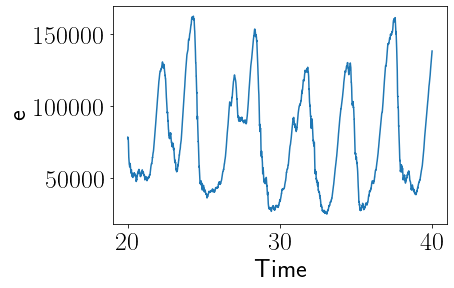

In [15]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILL_nDSW_infinitecanyon_irregular/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILL_nDSW_infinitecanyon_irregular_APE_cdwonly_relsponging.nc')

<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-24
<xarray.DataArray 'e' (Time: 7300, yh: 124, xh: 1000)>
dask.array<sub, shape=(7300, 124, 1000), dtype

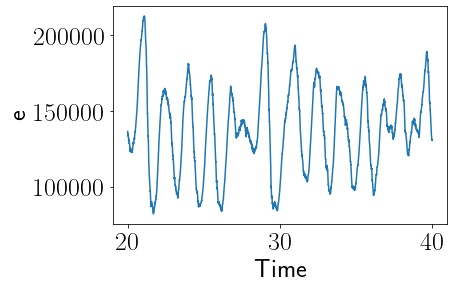

In [16]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILL_nDSW_infinitecanyon_irregular_halfg/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILL_nDSW_infinitecanyon_halfg_APE_cdwonly_relsponging.nc')

<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 51.0 51.0 51.01 51.01 ... 70.99 70.99 71.0 71.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-19
<xarray.DataArray 'e' (Time: 7300, yh: 119, xh: 1000)>
dask.array<sub, shape=(7300, 119, 1000), dtype

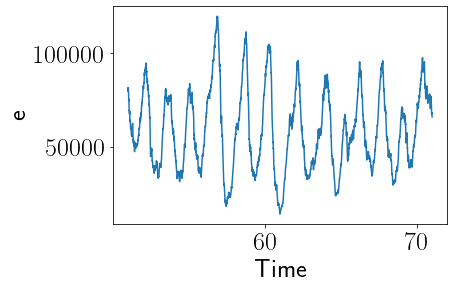

In [20]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02/', 51,71)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_APE_cdwonly_relsponging.nc')


In [21]:
APE_cdw.mean().values

array(3.4147392e+09, dtype=float32)

Text(0.5, 1.0, '')

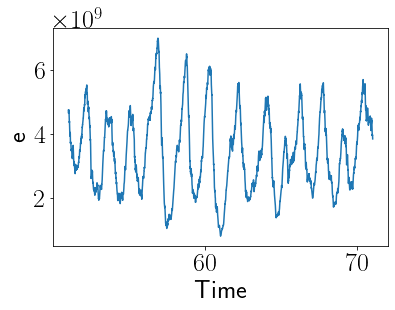

In [22]:
APE_cdw.plot()
plt.title('')

<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-19
<xarray.DataArray 'e' (Time: 7300, yh: 119, xh: 1000)>
dask.array<sub, shape=(7300, 119, 1000), dtype

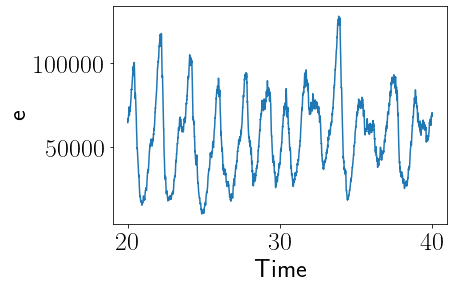

In [24]:
 APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag1p5e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag1p5e-03_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-20
<xarray.DataArray 'e' (Time: 7300, yh: 120, xh: 1000)>
dask.array<sub, shape=(7300, 120, 1000), dtype

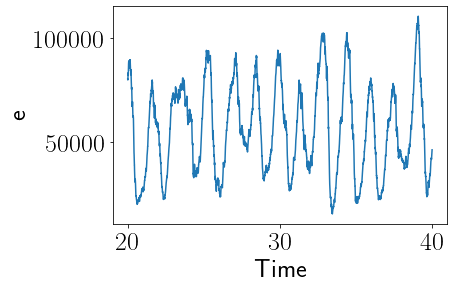

In [16]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag2p4e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag2p4e-03_APE_cdwonly_relsponging.nc')

<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-20
<xarray.DataArray 'e' (Time: 7300, yh: 120, xh: 1000)>
dask.array<sub, shape=(7300, 120, 1000), dtype

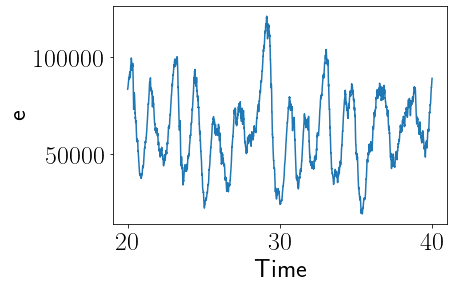

In [25]:
 APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag3p6e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag3p6e-03_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03


Task exception was never retrieved
future: <Task finished name='Task-686395' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-686394' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
fut

-19
<xarray.DataArray 'e' (Time: 7300, yh: 119, xh: 1000)>
dask.array<sub, shape=(7300, 119, 1000), dtype=float32, chunksize=(20, 119, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -18.5 -17.5 -16.5 -15.5 -14.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
    zi       float64 1.028e+03
MAPE loading ..
saved in 


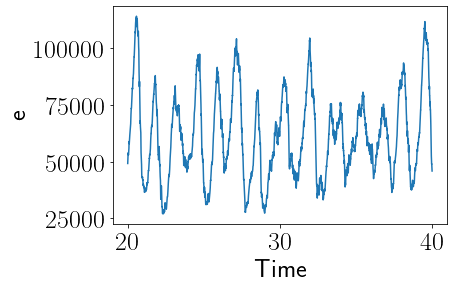

In [43]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag4p5e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag4p5e-03_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-20
<xarray.DataArray 'e' (Time: 7300, yh: 120, xh: 1000)>
dask.array<sub, shape=(7300, 120, 1000), dtype

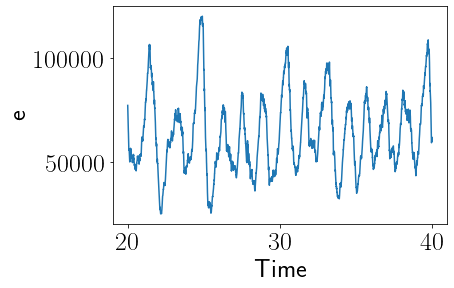

In [26]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag6p0e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag6p0e-03_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 30.0 30.0 30.01 30.01 ... 49.99 49.99 50.0 50.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-26
<xarray.DataArray 'e' (Time: 7300, yh: 126, xh: 1000)>
dask.array<sub, shape=(7300, 126, 1000), dtype

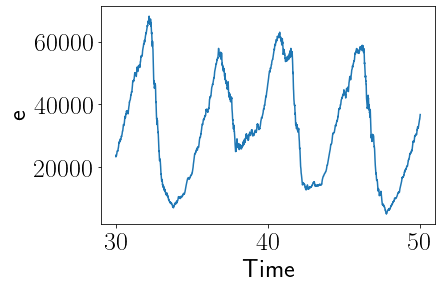

In [32]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau2p5e-02_sig1p0e+02/', 30,50)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau2p5e-02_sig1p0e+02_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-23
<xarray.DataArray 'e' (Time: 7300, yh: 123, xh: 1000)>
dask.array<sub, shape=(7300, 123, 1000), dtype

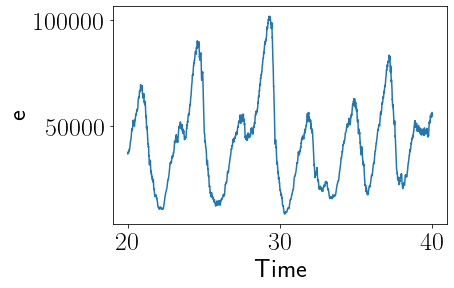

In [33]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau5p0e-02_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau5p0e-02_sig1p0e+02_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-21
<xarray.DataArray 'e' (Time: 7300, yh: 121, xh: 1000)>
dask.array<sub, shape=(7300, 121, 1000), dtype

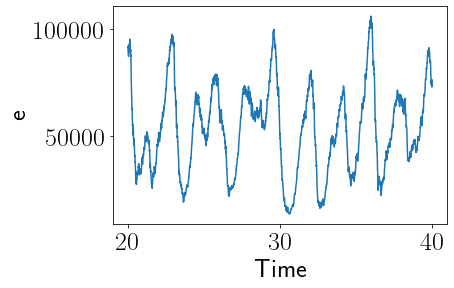

In [34]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau7p5e-03_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau7p5e-03_sig1p0e+02_APE_cdwonly_relsponging.nc')


<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 20.0 20.0 20.01 20.01 ... 39.99 39.99 40.0 40.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
<xarray.DataArray 'e' ()>
dask.array<neg, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    yh       float64 249.5
    zi       float64 1.028e+03
-19
<xarray.DataArray 'e' (Time: 7300, yh: 119, xh: 1000)>
dask.array<sub, shape=(7300, 119, 1000), dtype

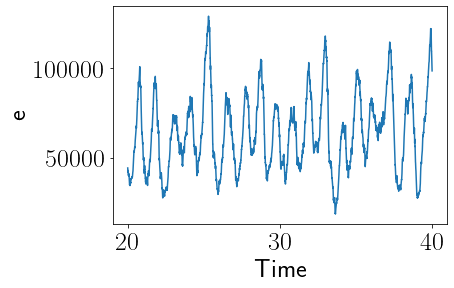

In [35]:
APE_cdw = timeseriesMAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p2e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p2e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+022_APE_cdwonly_relsponging.nc')


In [16]:
def MAPE_equil(filename):
    MAPE_time = xr.open_mfdataset(filename)
    MAPE_equil_mag = MAPE_time.mean(dim = 'Time')
    print(MAPE_equil_mag.e.values)
    return MAPE_equil_mag.e.values

In [38]:
fn = '/g/data/v45/qo9901/magnitude_drag_APE_cdwonly_relsponging.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [39]:
cdrag_exp = ds.createDimension('cdrag_exp',6)
cdrag_exps = ds.createVariable('cdrag_exp', 'f4', ('cdrag_exp',))
value = ds.createVariable('value', 'f4', ('cdrag_exp',))

In [40]:
c.run(gc.collect)


{'tcp://127.0.0.1:33587': 52,
 'tcp://127.0.0.1:34939': 73,
 'tcp://127.0.0.1:38179': 52,
 'tcp://127.0.0.1:39145': 52}

In [41]:
value[0] = MAPE_equil('4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag1p5e-03_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[1] = MAPE_equil('4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag2p4e-03_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[2] = MAPE_equil('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[3] = MAPE_equil('4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag3p6e-03_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[4] = MAPE_equil('4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag4p5e-03_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[5] = MAPE_equil('4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag6p0e-03_APE_cdwonly_relsponging.nc')


3296380200.0
3313310500.0
3414739200.0
3635063300.0
3582729500.0
3734570200.0


In [42]:
ds.close()

In [43]:
fn = '/g/data/v45/qo9901/magnitude_wind_APE_cdwonly_relsponging.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [44]:
wind_exp = ds.createDimension('wind_exp',5)
wind_exps = ds.createVariable('wind_exp', 'f4', ('wind_exp',))
value = ds.createVariable('value', 'f4', ('wind_exp',))

In [45]:
value[0] = MAPE_equil('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau2p5e-02_sig1p0e+02_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[1] = MAPE_equil('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau5p0e-02_sig1p0e+02_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[2] = MAPE_equil('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau7p5e-03_sig1p0e+02_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[3] = MAPE_equil('4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_APE_cdwonly_relsponging.nc')
c.run(gc.collect)
value[4] = MAPE_equil('4layer_fresh_tau1p2e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+022_APE_cdwonly_relsponging.nc')

2020178300.0
2529583000.0
3132836400.0
3414739200.0
3736187100.0


In [46]:
ds.close()

In [19]:
magnitude_drag_APE_cdw_ds = xr.open_mfdataset('/g/data/v45/qo9901/magnitude_drag_APE_cdwonly_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
magnitude_wind_APE_cdw_ds = xr.open_mfdataset('/g/data/v45/qo9901/magnitude_wind_APE_cdwonly_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
#magnitude_drag_MAPE_cdw.nc
magnitude_drag_APE_cdw = magnitude_drag_APE_cdw_ds.value.load().values
magnitude_wind_APE_cdw = magnitude_wind_APE_cdw_ds.value.load().values

[2.5e-07 4.0e-07 5.0e-07 6.0e-07 7.5e-07 1.0e-06]
2.5e-07 385425000.00000006
4e-07 986688000.0
5e-07 1541700000.0000002
6e-07 2220048000.0
7.5e-07 3468825000.000001
1e-06 6166800000.000001


(-10000000.0, 6500000000.0)

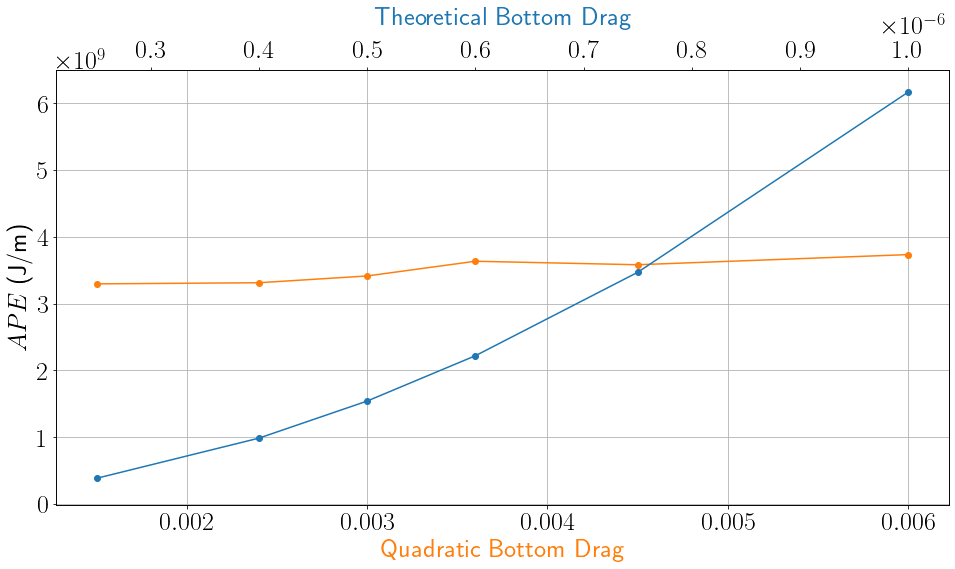

In [59]:
drag_matrix = np.asarray([1.5e-3, 2.4e-3,3e-3,3.6e-3,4.5e-3,6e-3])*1e-5
cdrag_new = 5e-7
drag_matrix = np.asarray([cdrag_new*0.5,cdrag_new*0.8,cdrag_new,cdrag_new*1.2,cdrag_new*1.5,cdrag_new*2])
print(drag_matrix)## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
plt.figure(figsize = (16,8))
ax1 = plt.subplot()
APE_cdw_drag_predict_matrix = [MAPE_predict(drag_matrix[i]) for i in range(len(drag_matrix))] ## APE ~ O(1e7)
drag_plot_matrix = np.asarray([1.5e-3, 2.4e-3,3e-3,3.6e-3,4.5e-3,6e-3]) ## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
ax2 = ax1.twiny()

ax2.plot(drag_matrix, APE_cdw_drag_predict_matrix, label = 'Theory (200km ASC)', marker = 'o')
#plt.plot(drag_plot_matrix, np.asarray([3.952531e+08, 1.016263e+09, 1.572045e+09, 2.249446e+09,3.613775e+09,6.074820e+09,]), label = 'Theory IVP (200km ASC)') #old but whatever
ax1.plot(drag_plot_matrix, magnitude_drag_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1') #*1e6 is old APE cdw
## MAPE calculates and saves as sum over xh and yh,dx, dy contribution in the xgcm?
## to get the mean in longitudinal direction - nc_file len_x
## len_x  = 1000km
## 
ax1.set_ylabel('$APE$ (J/m)')
ax2.set_xlabel('Theoretical Bottom Drag', color = 'C0', labelpad = 15)
ax1.set_xlabel('Quadratic Bottom Drag', color = 'C1')
ax1.grid(which  = 'both')
plt.ylim([-0.01e9,6.5e9])

5e-07 1541700000.0000002


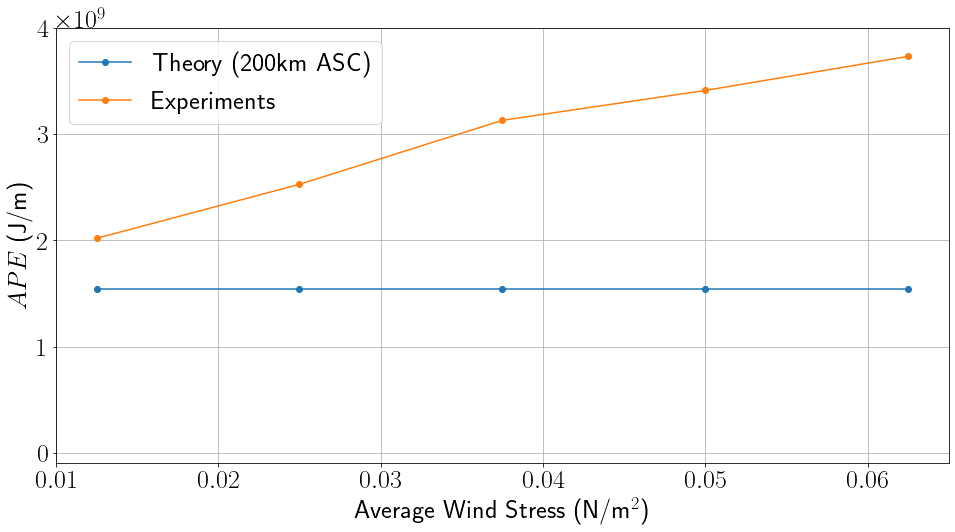

In [36]:
tau_matrix = np.asarray([0.025,0.05,0.075,0.1, 0.125])/2
plt.figure(figsize = (16,8))
T_matrix = np.ones(len(tau_matrix))*MAPE_predict(5e-7)

#plt.ylim([400,2400])
#plt.ylim([0,2400])
#plt.ylim([0,5e9])


plt.plot(tau_matrix, T_matrix, label = 'Theory (200km ASC)', marker = 'o', color = 'C0')
#plt.plot(tau_matrix, np.asarray([1.544042e+09,1.572045e+09,1.594390e+09,1.571158e+09,1.590986e+09]), label = 'Theory IVP (200km ASC)', color = 'C0')

#ax1.set_ylim([-0.1e11,0.9e11])
#ax1.set_yticks(np.arange(-0.1e11, 0.9e11, 1e10))
plt.ylabel(' $APE$ (J/m)')

plt.plot(tau_matrix, magnitude_wind_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1')
plt.xlabel('Average Wind Stress (N/m$^2$)')
plt.grid(which  = 'both')
plt.ylim([-0.1e9,4e9])
plt.legend()